# SSD

In [1]:
import torch
from d2l import torch as d2l
import torchvision
from torch import nn
from torch.nn import functional as F

In [2]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes +1), kernel_size=3, padding=1)

In [3]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors*4, kernel_size=3, padding=1)

In [4]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape


(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [5]:
# 这段代码包含两个函数，分别用于处理目标检测模型输出的预测张量：

def flatten_pred(pred):
    # 先对输入pred的维度重新排列，将通道维（num_channels）挪到最后，得到(N, H, W, C)
    # 再拉平成二维(N, -1)（其中-1为自动计算），便于后续拼接与损失计算
    return torch.flatten(torch.permute(pred, (0, 2, 3, 1)), start_dim=1)

def concat_preds(preds):
    # preds 是多个特征层输出的预测列表
    # 先把每个特征层的预测flatten，最后沿着维度1拼接（即每个batch对应所有anchor的预测拼在一起）
    return torch.cat([flatten_pred(pred) for pred in preds], dim=1)

In [6]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [7]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [8]:
forward(torch.zeros(2,3,20,20), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [9]:
def base_net():
    blk = []
    num_filter = [3, 16, 32, 64]
    for i in range(len(num_filter) -1):
        blk.append(down_sample_blk(num_filter[i], num_filter[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros(2,3,256, 256), base_net()).shape

torch.Size([2, 64, 32, 32])

In [10]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    
    return blk

In [11]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbpx_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbpx_preds)


In [12]:
# sizes: 每个锚框集合对应的缩放比例（即 box 的不同尺寸），每个列表内的两个数分别代表为该层生成 anchor 时用到的两种 size
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]

# ratios: 每个锚框集合（对应 feature map 一个位置）用的宽高比，都是 [1, 2, 0.5]
ratios = [[1, 2, 0.5]] * 5  # 总共五层 feature，各自都用这三个宽高比
print("ratios 表示每一个特征层用于生成锚框的高宽比:", ratios)

# 每个特征图位置（像素点）会产生多少个 anchor
# 按 SSD 的锚框生成方式，每个位置会有 len(ratios) 个比例和 len(sizes) - 1 个附加框（因为第一个 size 和第一个 ratio 特殊组合），详见原论文
num_anchors = len(sizes[0]) + len(ratios[0]) - 1  # 得到每个像素/位置对应的 anchor 数量
print(f"每个特征层每个位置生成 {num_anchors} 个锚框(anchor)")



ratios 表示每一个特征层用于生成锚框的高宽比: [[1, 2, 0.5], [1, 2, 0.5], [1, 2, 0.5], [1, 2, 0.5], [1, 2, 0.5]]
每个特征层每个位置生成 4 个锚框(anchor)


In [13]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [14]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [15]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size=batch_size)

read 1000 training examples
read 100 validation examples


In [16]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [17]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds,cls_labels, bbox_preds, bbox_labels,  bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [18]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

In [19]:
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

KeyboardInterrupt: 

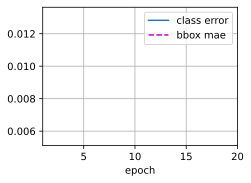

In [20]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])

net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, labels in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), labels.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        l = calc_loss(cls_preds=cls_preds, cls_labels=cls_labels, bbox_preds=bbox_preds, bbox_labels=bbox_labels, bbox_masks=bbox_masks)
        # l是一个batch中每个样本的损失(mean(dim=1)后是[batch_size]，所以l是[batch_size]的张量)
        # l.mean()表示对整个batch的损失再取平均，作为整体损失用于反向传播
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    # 计算分类错误率 (cls_err) 和边界框的平均绝对误差 (bbox_mae)
    # metric[0]: 累加的分类预测正确的样本数
    # metric[1]: 分类总样本数
    # 因此 1 - (正确数/总数) 就是分类错误率
    # metric[2]: 累加的所有预测框的误差总和
    # metric[3]: 边界框的总元素数
    # 两者相除得到平均每个元素的绝对误差
    cls_err = 1 - metric[0] / metric[1]
    bbox_mae = metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

In [ ]:
X = torchvision.io.read_image('../img/banana.jpg')
# unsqueeze(0)的意思是在第0维增加一个维度，把 [C, H, W] 变成 [1, C, H, W]，常用于添加batch维
X = X.unsqueeze(0).float()
# 这里将形状 [1, C, H, W] 的 X 先去掉 batch 维（squeeze(0)），变为 [C, H, W]，
# 然后 permute(1, 2, 0) 把顺序从 [C, H, W] -> [H, W, C]，最后转为 long 类型，适合后续可视化或处理。
img = X.squeeze(0).permute(1, 2, 0).long()

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)